<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/week%205/embed_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!unzip "/content/ncbi_dataset (1) (2).zip"


Archive:  /content/ncbi_dataset (1) (2).zip
  inflating: README.md               
  inflating: ncbi_dataset/data/gene.fna  
  inflating: ncbi_dataset/data/rna.fna  
  inflating: ncbi_dataset/data/protein.faa  
  inflating: ncbi_dataset/data/data_report.jsonl  
  inflating: ncbi_dataset/data/product_report.jsonl  
  inflating: ncbi_dataset/data/dataset_catalog.json  
  inflating: md5sum.txt              


In [ ]:
import pandas as pd
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [ ]:
o = pd.read_json("ncbi_dataset/data/data_report.jsonl", lines=True)

In [ ]:
cols = list(set(o["geneOntology"].explode()))
p = pd.DataFrame(columns=cols)

In [ ]:
p

,biologicalProcesses,cellularComponents,molecularFunctions,EnsemblId,gene
0,"[[ERBB2-EGFR signaling pathway, involved_in], ...","[[Golgi apparatus, located_in], [Golgi apparat...","[[ATP binding, enables], [ATPase binding, enab...",[ENSG00000146648],EGFR
1,"[[AMPA glutamate receptor clustering, acts_ups...","[[Golgi apparatus, located_in], [blood micropa...","[[amyloid-beta binding, enables], [amyloid-bet...",[ENSG00000130203],APOE
2,"[[T follicular helper cell differentiation, in...","[[endoplasmic reticulum lumen, located_in], [e...","[[cytokine activity, enables], [cytokine activ...",[ENSG00000136244],IL6
3,"[[ATP biosynthetic process, involved_in], [Lan...","[[Golgi lumen, located_in], [axon, located_in]...","[[cytokine activity, enables], [cytokine activ...",[ENSG00000105329],TGFB1
4,"[[JNK cascade, acts_upstream_of], [animal orga...","[[cell surface, located_in], [external side of...","[[cytokine activity, enables], [cytokine activ...",[ENSG00000232810],TNF
5,"[[B cell lineage commitment, acts_upstream_of_...","[[PML body, located_in], [PML body, located_in...","[[14-3-3 protein binding, enables], [ATP-depen...",[ENSG00000141510],TP53
6,"[[VEGF-activated neuropilin signaling pathway,...","[[Golgi apparatus, located_in], [VEGF-A comple...","[[chemoattractant activity, enables], [chemoat...",[ENSG00000112715],VEGFA


In [ ]:
o["geneOntology"].iloc[0]['biologicalProcesses']
for i in range(len(o)):
  for key,value in o["geneOntology"].iloc[i].items():
    a = []
    for j in value:
      a.append([j["name"], j["qualifier"]])
    p.loc[i, key] = a

In [ ]:
p["EnsemblId"] = o["ensemblGeneIds"]
p["gene"] = o["symbol"]

In [ ]:
genes = []
proteins = []
for record in SeqIO.parse("ncbi_dataset/data/gene.fna", "fasta"):
    accession_id = record.description.split(" ")[0].split(":")[0]
    gene = record.description.split(" ")[1]
    start = record.description.split(" ")[0].split(":")[1].split("-")[0].strip("c")
    end = record.description.split(" ")[0].split(":")[1].split("-")[1]
    chromosome = record.description.split(" ")[5].split("=")[1].strip("]")
    gene_seq = str(record.seq)
    genes.append([accession_id, gene, chromosome, start, end, gene_seq])


In [ ]:
df = pd.DataFrame(genes, columns=['accession_id', 'gene', 'chromosome', 'start', 'end' ,'gene_seq'])
df.drop_duplicates(inplace = True)
df_protein = pd.DataFrame(proteins, columns=['accession_id','gene', 'protein_seq'])
df_protein.drop_duplicates(inplace=True)


In [ ]:
df = df.merge(df_protein, on=['accession_id','gene'], how='left')
df = df.merge(p, on='gene', how='left')
df["protein_seq"]= df["gene_seq"].apply(lambda x: str(Seq(x).translate()))

In [ ]:
def one_hot_encode_gene(seq):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = [mapping.get(base, [0, 0, 0, 0]) for base in seq]
    return encoded_seq

df['gene_seq'] = df['gene_seq'].apply(one_hot_encode_gene)

In [ ]:
def one_hot_encode_protein(seq):
    # Include stop codon '*' in the mapping
    mapping = {
        'A': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'R': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'N': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'D': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'C': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Q': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'E': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'G': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'H': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'I': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'L': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'M': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        'F': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        'S': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        'T': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        'W': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        'Y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        'V': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        '*': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # Stop codon
        'X': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] # Unknown amino acid
    }
    encoded_seq = [mapping.get(amino_acid, [0] * 21) for amino_acid in seq]
    return encoded_seq

df['protein_seq'] = df['protein_seq'].apply(one_hot_encode_protein)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
df['molecular_documents'] = df['molecularFunctions'].apply(lambda pairs: [' '.join(p) for p in pairs])
all_docs = [doc for sublist in df['molecular_documents'] for doc in sublist]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_docs)
# --- End of previous code ---


# 1. Convert the sparse matrix to a list of vectors for easier handling
# Each item in this list is one vector (represented as a list of floats)
list_of_all_vectors = tfidf_matrix.toarray().tolist()


# 2. Distribute the vectors back to their original rows
vectors_for_each_row = []
current_position = 0
for docs_in_row in df['molecular_documents']:
    # Find how many vectors belong to this row
    num_vectors_in_row = len(docs_in_row)

    # Slice that many vectors from our flat list
    row_vectors = list_of_all_vectors[current_position : current_position + num_vectors_in_row]
    vectors_for_each_row.append(row_vectors)

    # Move the starting position for the next row
    current_position += num_vectors_in_row


# 3. Add the result as a new column in the DataFrame
df['molecular_embeddings'] = vectors_for_each_row

In [ ]:
df['biological_documents'] = df['biologicalProcesses'].apply(lambda pairs: [' '.join(p) for p in pairs])
all_docs = [doc for sublist in df['biological_documents'] for doc in sublist]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_docs)
# --- End of previous code ---


# 1. Convert the sparse matrix to a list of vectors for easier handling
# Each item in this list is one vector (represented as a list of floats)
list_of_all_vectors = tfidf_matrix.toarray().tolist()


# 2. Distribute the vectors back to their original rows
vectors_for_each_row = []
current_position = 0
for docs_in_row in df['biological_documents']:
    # Find how many vectors belong to this row
    num_vectors_in_row = len(docs_in_row)

    # Slice that many vectors from our flat list
    row_vectors = list_of_all_vectors[current_position : current_position + num_vectors_in_row]
    vectors_for_each_row.append(row_vectors)

    # Move the starting position for the next row
    current_position += num_vectors_in_row


# 3. Add the result as a new column in the DataFrame
df['biological_embeddings'] = vectors_for_each_row

In [ ]:
df['cellular_documents'] = df['cellularComponents'].apply(lambda pairs: [' '.join(p) for p in pairs])
all_docs = [doc for sublist in df['cellular_documents'] for doc in sublist]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_docs)
# --- End of previous code ---


# 1. Convert the sparse matrix to a list of vectors for easier handling
# Each item in this list is one vector (represented as a list of floats)
list_of_all_vectors = tfidf_matrix.toarray().tolist()


# 2. Distribute the vectors back to their original rows
vectors_for_each_row = []
current_position = 0
for docs_in_row in df['cellular_documents']:
    # Find how many vectors belong to this row
    num_vectors_in_row = len(docs_in_row)

    # Slice that many vectors from our flat list
    row_vectors = list_of_all_vectors[current_position : current_position + num_vectors_in_row]
    vectors_for_each_row.append(row_vectors)

    # Move the starting position for the next row
    current_position += num_vectors_in_row


# 3. Add the result as a new column in the DataFrame
df['cellular_embeddings'] = vectors_for_each_row

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
df['gene_seq'] = df['gene_seq'].apply(lambda x: np.array(x))
df['protein_seq'] = df['protein_seq'].apply(lambda x: np.array(x))

In [ ]:
X = df[['gene_seq', 'protein_seq', 'molecular_embeddings', 'biological_embeddings', 'cellular_embeddings']]
X = torch.tensor(X.values, dtype=torch.float32)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
# Convert list of lists/arrays in specified columns to tensors and handle variable lengths
X_list = []
for index, row in df[['gene_seq']].iterrows():
    gene_seq_tensor = torch.tensor(row['gene_seq'], dtype=torch.float32).flatten()
    X_list.append(gene_seq_tensor)


# Pad sequences if necessary (handling variable length inputs)
# For simplicity, we'll pad to the maximum length found in the dataset.
# A more robust approach might involve padding within batches or using RNNs/LSTMs.

max_len = max(tensor.size(0) for tensor in X_list)
padded_X_list = []
for tensor in X_list:
    padding_size = max_len - tensor.size(0)
    padded_tensor = torch.nn.functional.pad(tensor, (0, padding_size))
    padded_X_list.append(padded_tensor)


# Stack the tensors to create the final input tensor X
X = torch.stack(padded_X_list)

print("Shape of the final input tensor X:", X.shape)

Shape of the final input tensor X: torch.Size([21, 772480])


In [ ]:
from torch.utils.data import dataset, dataloader

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X)

trainloader = DataLoader(dataset, batch_size=32, shuffle=True) # You can adjust batch_size and shuffle as needed

In [ ]:
from diffusers import AutoencoderKL

In [ ]:
from enum import auto
# prompt: Using autoecnoderkl train using trainloader abover
input_dim = X.size(-1)
# Assuming AutoencoderKL is initialized and defined as `autoencoderkl`
# Assuming the model is moved to the appropriate device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Replace AutoencoderKL with the custom SimpleAutoencoder
autoencoder = SimpleAutoencoder(input_dim).to(device)

# Define loss function (Mean Squared Error is common for reconstruction)
criterion = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4) # Adjust learning rate as needed

# Training loop
num_epochs = 10 # Adjust number of epochs as needed

# No need to move model to device again here, it's already done above
# autoencoderkl.to(device)

for epoch in range(num_epochs):
  autoencoder.train()
  running_loss = 0.0
  for data in trainloader:
    # Assuming the data is a tuple, take the first element which is your tensor
    inputs = data[0].to(device)

    # The SimpleAutoencoder expects a flattened input, no need to reshape to 4D
    # inputs = inputs.view(inputs.size(0), 1, 1, -1)


    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    # Use the custom autoencoder
    outputs = autoencoder(inputs) # Access the reconstructed sample

    # Calculate loss
    loss = criterion(outputs, inputs)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)

  epoch_loss = running_loss / len(trainloader.dataset)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Finished Training')

Epoch [1/10], Loss: 0.0346
Epoch [2/10], Loss: 0.0346
Epoch [3/10], Loss: 0.0345
Epoch [4/10], Loss: 0.0345
Epoch [5/10], Loss: 0.0344
Epoch [6/10], Loss: 0.0344
Epoch [7/10], Loss: 0.0343
Epoch [8/10], Loss: 0.0343
Epoch [9/10], Loss: 0.0342
Epoch [10/10], Loss: 0.0342
Finished Training


In [ ]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)# Latent dimension
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        # Flatten the input for the linear layers
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Reshape the output back to the original input shape (optional, depending on how you use the output)
        # decoded = decoded.view(decoded.size(0), 1, 1, -1) # Uncomment if you need the 4D output
        return decoded

# Get the input dimension from the shape of X
input_dim = X.size(-1)

# Instantiate the custom autoencoder model
autoencoder = SimpleAutoencoder(input_dim)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

print(f"SimpleAutoencoder model created with input dimension: {input_dim}")

SimpleAutoencoder model created with input dimension: 772480


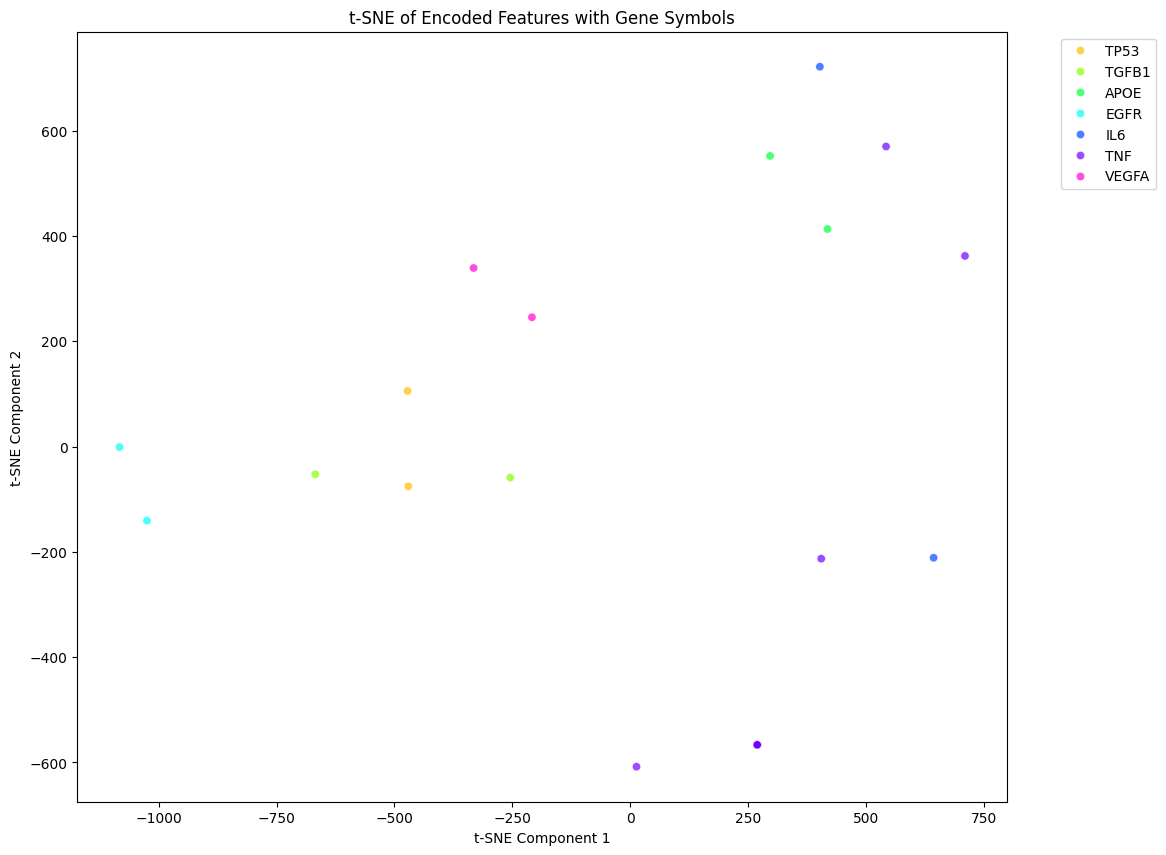

In [ ]:
# prompt: plot the encoded features tsne with gene symbol as label

import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Get the encoded features
autoencoder.eval()
with torch.no_grad():
    # The autoencoder expects a flattened input
    X_flat = X.view(X.size(0), -1).to(device)
    encoded_features = autoencoder.encoder(X_flat).cpu().numpy()

# Perform t-SNE dimensionality reduction
# Set perplexity to a value less than the number of samples (21)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(encoded_features)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['gene_symbol'] = df['gene']

# Plot the t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="gene_symbol",
    palette=sns.color_palette("hsv", len(tsne_df['gene_symbol'].unique())),
    data=tsne_df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE of Encoded Features with Gene Symbols')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()